In [18]:
import numpy as np
from scipy import stats
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
def cohen_d(x, y):
    """Compute Cohen's d for effect size."""
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def cliffs_delta(x, y):
    """Compute Cliff's delta for effect size."""
    m, n = len(x), len(y)
    more = sum((xi > yj) for xi in x for yj in y)
    less = sum((xi < yj) for xi in x for yj in y)
    return (more - less) / (m * n)

def partition(groups, effect_size_func):
    """Find the partition that maximizes the between-group sum of squares."""
    total_mean = np.mean([item for group in groups for item in group])
    total_ss = sum((item - total_mean) ** 2 for group in groups for item in group)
    
    best_split = None
    max_ss_between = 0
    
    for i in range(1, len(groups)):
        left = groups[:i]
        right = groups[i:]
        
        left_mean = np.mean([item for group in left for item in group])
        right_mean = np.mean([item for group in right for item in group])
        
        ss_between = (len(left) * (left_mean - total_mean) ** 2 +
                      len(right) * (right_mean - total_mean) ** 2)
        
        if ss_between > max_ss_between:
            max_ss_between = ss_between
            best_split = (left, right)
    
    return best_split, max_ss_between

def scott_knott_esd(data, alpha=0.05, effect_size_threshold=0.5, parametric=True):
    """
    Perform the Scott-Knott ESD test.
    :param data: A dictionary with model names as keys and lists of performance scores as values.
    :param alpha: Significance level for the initial test.
    :param effect_size_threshold: Threshold for considering effect size as non-negligible.
    :param parametric: Whether to use parametric or non-parametric tests.
    :return: A list of groups with ranked model names.
    """
    models = list(data.keys())
    scores = list(data.values())
    
    # Perform initial statistical test
    if parametric:
        f_value, p_value = stats.f_oneway(*scores)
        effect_size_func = cohen_d
    else:
        h_value, p_value = stats.kruskal(*scores)
        effect_size_func = cliffs_delta
    
    if p_value > alpha:
        print("No significant differences between models.")
        return [models]
    
    # Sort models by their mean performance
    mean_scores = {model: np.mean(score) for model, score in data.items()}
    sorted_models = sorted(mean_scores, key=mean_scores.get, reverse=True)
    
    # Initialize clusters
    clusters = [[model] for model in sorted_models]
    
    # Recursive function to split clusters
    def split_cluster(cluster):
        if len(cluster) <= 1:
            return [cluster]
        
        # Prepare data for partitioning
        group_data = [data[model] for model in cluster]
        
        # Find the best partition
        best_split, max_ss_between = partition(group_data, effect_size_func)
        
        if best_split is None:
            return [cluster]
        
        left_models = [model for model in cluster if data[model] in best_split[0]]
        right_models = [model for model in cluster if data[model] in best_split[1]]
        
        # Calculate effect sizes between groups
        effect_sizes = [effect_size_func(data[l], data[r]) for l in left_models for r in right_models]
        
        if all(abs(es) < effect_size_threshold for es in effect_sizes):
            return [cluster]
        else:
            return split_cluster(left_models) + split_cluster(right_models)
    
    # Apply the recursive splitting
    final_clusters = split_cluster(sorted_models)
    
    return final_clusters


def show_ranking_as_boxplots(ranked_models, data, system_name='', metric_name='score', palette='hls', fliers=True, 
                             fonts=11, figs=(2,4), y_lims=(None, 2)):
    """It shows the ranking of models and their groups as boxplots
    """

    # Flatten the ranked models list to get the order
    model_order = [model for group in ranked_models for model in group]

    df = pd.DataFrame({
        'Model': [model for model, scores in data.items() for _ in scores],
        'Score': [score for scores in data.values() for score in scores]
    })
    min_y = df['Score'].min().min()
    # print(min_y)

    # Generate a color palette with one color per model
    all_models = set(model_order)
    unique_colors = sns.color_palette(palette, n_colors=len(all_models)) 
    model_colors = dict(zip(all_models, unique_colors))

    # Plotting subplots in a horizontal layout
    width_ratios = [len(group) for group in ranked_models]
    fig_width = sum(width_ratios) * figs[0]

    # Plotting subplots in a horizontal layout
    num_groups = len(ranked_models)
    fig, axes = plt.subplots(1, num_groups, figsize=(fig_width, figs[1]), width_ratios=width_ratios, sharey=True)

    # Make sure axes is a list even if there is only one subplot
    if num_groups == 1:
        axes = [axes]

    for i, group in enumerate(ranked_models):
        # Select data for the current group
        group_df = df[df['Model'].isin(group)]
        # Plot with custom color for each model
        sns.boxplot(ax=axes[i], x='Model', y='Score', data=group_df, order=group, hue=group_df['Model'], 
                    showfliers=fliers, palette=model_colors) #, width=width)
        axes[i].set_title(f'Group {i+1}', fontsize=fonts)
        axes[i].set(xlabel=None)
        if i == 0:  # Only set the y-label for the first subplot
            axes[i].set_ylabel(metric_name, fontsize=fonts)
            # axes[i].set(ylim=(min_y, 1))
        else:
            axes[i].set_ylabel('', fontsize=fonts)

    # Adjust layout
    if y_lims[1] is not None:
        plt.gca().set_ylim(top=y_lims[1])
    if y_lims[0] is not None:
        plt.gca().set_ylim(bottom=y_lims[0])
    plt.tight_layout()
    plt.suptitle(system_name+' Model Performance Ranking (Cross-Validation)', y=1.05)
    plt.show()


In [20]:
def get_dataframe_for_classifier(evaluations_df, target_metric, system_name, classifier_name):
    # Utility  to convert the evaluations into the proper format for running the tests, and also generating the visualizations
    system_metric_filter_cols = [col for col in evaluations_df.columns if (target_metric in col) and (system_name in col)]
    print(target_metric, system_name, system_metric_filter_cols)
    df = evaluations_df[system_metric_filter_cols]
    df.columns = [classifier_name+" - "+col.split('-')[1].strip() for col in system_metric_filter_cols]
    return df.dropna()

In [21]:
FILENAME_XGBOOST = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/naive_performance_xgboost_100nfold.csv'
FILENAME_RFOREST = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/naive_performance_rforest_100nfold.csv'

xgboost_evaluations_df = pd.read_csv(FILENAME_XGBOOST)
# print(xgboost_evaluations_df.columns)
# xgboost_evaluations_df

rf_evaluations_df = pd.read_csv(FILENAME_RFOREST)
# print(rf_evaluations_df.columns)
# rf_evaluations_df

In [22]:
# Visualization of the ranking of models for a particular system and target metric
target_metric = 'r2' # 'neg_median_absolute_error' 'r2' 'neg_root_mean_squared_error'
system_name = 'COCOME' # 'STPLUS' 'COCOME'

df1 = get_dataframe_for_classifier(xgboost_evaluations_df, target_metric, system_name, classifier_name='xgboost')
df2 = get_dataframe_for_classifier(rf_evaluations_df, target_metric, system_name, classifier_name='rf')

df = pd.concat([df1, df2], axis=1)
df

r2 COCOME ['COCOME - t - r2', 'COCOME - e - r2', 'COCOME - t & e - r2']
r2 COCOME ['COCOME - t - r2', 'COCOME - e - r2', 'COCOME - t & e - r2']


,xgboost - t,xgboost - e,xgboost - t & e,rf - t,rf - e,rf - t & e
0,-1.227832e+29,-6.396721e+31,-8.287491e+23,-1.126157e+30,-6.997440e+31,-1.861257e+24
1,-4.204395e-01,2.457236e-01,-4.204395e-01,-4.204547e-01,1.297332e-01,9.063295e-02
2,5.582290e-01,-6.970882e-01,5.880429e-01,5.231517e-01,-6.907402e-01,5.595282e-01
3,3.626842e-01,-8.945848e+00,2.880098e-01,3.536001e-01,-8.672214e+00,3.086082e-01
4,2.299465e-01,-1.345933e+00,-6.395882e-02,2.269029e-01,-1.297172e+00,1.284094e-01
5,-2.287417e+00,-3.051654e+03,5.828434e-01,-1.491762e+02,-1.543148e+04,-2.220593e+01
6,-5.163372e+00,-1.658050e+01,-1.008056e+01,-5.262594e+00,-1.048919e+01,-2.197945e+00
7,-8.931012e-01,-1.320203e+00,-5.544112e-01,-1.095256e+00,-6.754751e-01,-6.206655e-01
8,5.107206e-01,5.225767e-01,5.255994e-01,5.125856e-01,5.088625e-01,5.110568e-01
9,4.842901e-01,4.778960e-01,4.778960e-01,4.812609e-01,4.751562e-01,4.737967e-01


In [23]:
# df.drop(['xgboost - e', 'rf - e'], inplace=True, axis=1) # For R2 in STPLUS
# df.drop(['xgboost - e', 'rf - e'], inplace=True, axis=1) # For R2 in COCOME

No significant differences between models.
r2 COCOME Model ranking (non-Parametric): [['xgboost - t', 'xgboost - e', 'xgboost - t & e', 'rf - t', 'rf - e', 'rf - t & e']]


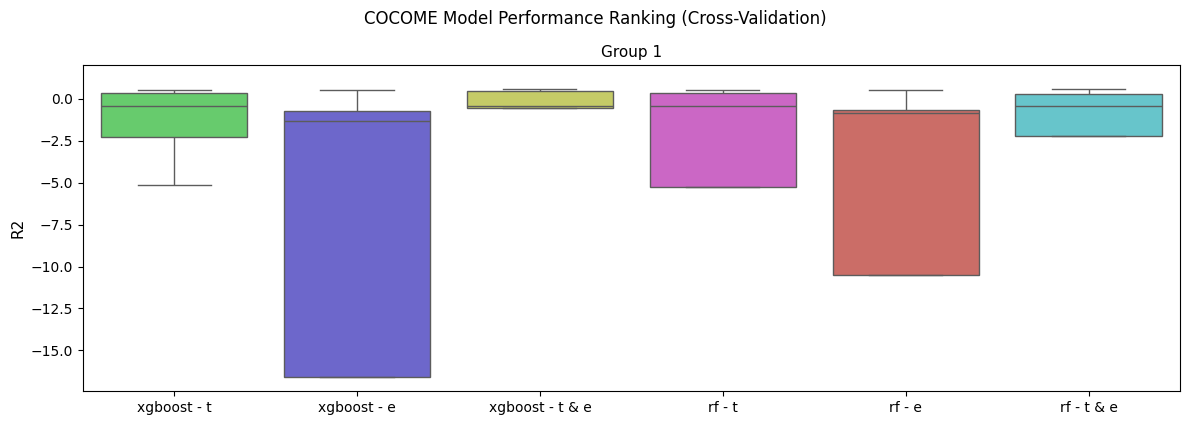

In [24]:
data = df.to_dict(orient='list')
# Non-parametric case
ranked_models_non_parametric = scott_knott_esd(data, parametric=False)
print(target_metric, system_name, "Model ranking (non-Parametric):", ranked_models_non_parametric)

show_ranking_as_boxplots(ranked_models_non_parametric, data, system_name=system_name, # y_lims=(-2,1.5),
                         metric_name=target_metric.upper(), fliers=False, figs=(2,4))